In [1]:
import itertools
import os
import pickle
import random
from typing import Any, Callable, Dict, Iterable, Iterator, List, Optional, Tuple, Union

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler

import intel_extension_for_pytorch as ipex
import schedulefree
from tqdm import tqdm, trange

from replay_loading import enum_replay_folder, files_to_strokes, sample_stroke

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

print(torch.__version__)
print(ipex.__version__)
[print(f'[{i}]: {torch.xpu.get_device_properties(i)}') for i in range(torch.xpu.device_count())]

device = torch.device("xpu")

2.1.0.post2+cxx11.abi
2.1.30.post0 
[0]: _DeviceProperties(name='Intel(R) Arc(TM) A770 Graphics', platform_name='Intel(R) Level-Zero', dev_type='gpu', driver_version='1.3.29803', has_fp64=0, total_memory=15930MB, max_compute_units=512, gpu_eu_count=512)


In [2]:
replay_fns = list(itertools.islice(enum_replay_folder("H:/osu!/Data/r/"), 300))
strokes_subset = list(files_to_strokes(tqdm(replay_fns), min_length=50))
sum((len(s[0]) for s in strokes_subset))

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:21<00:00, 13.92it/s]


1930021

In [47]:
class StrokeDataset(Dataset):
    def __init__(self, strokes, transforms=None):
        self.strokes = strokes
        self.transforms = transforms
        self.wrand_sampler = WeightedRandomSampler([len(s[0]) for s in strokes], len(strokes), replacement=True)

    def __len__(self):
        return len(self.strokes)

    def __getitem__(self, idx):
        sample = self.strokes[idx]
        
        # Apply the transformations if any
        if self.transforms:
            for transform in self.transforms:
                sample = transform(sample)
            return sample
        else:
            return sample[1]


class StrokeResample:
    def __init__(self, rate_range=(30, 250), max_length=2048):
        self.rate_range = rate_range
        self.max_length = max_length

    def __call__(self, sample):
        timings, positions = sample
        rate = np.random.uniform(*self.rate_range)
        offset = np.random.uniform(0, 1/rate)
        return sample_stroke(timings, positions, rate, offset, max_length=self.max_length)


class StrokeDiff:
    def __call__(self, sample):
        return np.diff(sample, axis=0)


class ScaleRotateFlip:
    def __init__(self, scale_range=(0.5, 1.5)):
        self.scale_range = scale_range

    def __call__(self, sample):
        scale = random.uniform(*self.scale_range)
        sample = sample * scale
        angle = random.uniform(-np.pi, np.pi)
        flip = random.choice([1, -1])
        rotation_matrix = np.array([
            [np.cos(angle), -flip * np.sin(angle)],
            [flip * np.sin(angle), np.cos(angle)]])
        sample = sample @ rotation_matrix
        return sample


class StrokeToTensor:
    def __call__(self, sample):
        return torch.from_numpy(sample).float()


def collate_pad_beginning_zeroes(batch):
    max_len = max([len(stroke) for stroke in batch])
    padded_batch = [F.pad(stroke, (0, 0, max_len - len(stroke), 0)) for stroke in batch]
    return torch.stack(padded_batch)


transforms = [
    StrokeResample(max_length=4096),
    StrokeDiff(),
    ScaleRotateFlip(),
    StrokeToTensor(),
]

batch_size = 256

ds_small = StrokeDataset(strokes_subset, transforms=transforms)
ds_small_loader = DataLoader(ds_small, batch_size=batch_size, sampler=ds_small.wrand_sampler, collate_fn=collate_pad_beginning_zeroes)

In [48]:
all_strokes = pickle.load(open("all_strokes.pkl", "rb"))

ds_full = StrokeDataset(all_strokes, transforms=transforms)
ds_full_loader = DataLoader(ds_full, batch_size=batch_size, sampler=ds_full.wrand_sampler, collate_fn=collate_pad_beginning_zeroes)

In [90]:
# class TestNet4(nn.Module):
class TestNet4(torch.jit.ScriptModule):
    def __init__(self, kernels=[5] * 12, channels=[8] * 4 + [4] * 4 + [2] * 4, dilations=None, out_steps=5):
        super().__init__()

        self.kernels = torch.tensor(kernels + [1])
        self.out_steps = out_steps
        self.channels = torch.tensor(channels + [2 * out_steps])
        self.in_channels = torch.tensor([2] + channels).cumsum(dim=0)
        self.total_channels = self.in_channels[-1].item() + 2
        self.dilations = torch.tensor(dilations + [1]) if dilations is not None else None
        self.pads = (self.kernels - 1) * (self.dilations if self.dilations is not None else 1)
        self.pad_total = self.pads.sum().item()
        self.pad_max = self.pads.max().item()
        self.ar_len = 5

        self.convs = nn.ModuleList(
            [
                nn.Conv1d(
                    in_channels=self.in_channels[i].item(),
                    out_channels=self.channels[i].item() * 2,
                    kernel_size=self.kernels[i].item(),
                    dilation=self.dilations[i].item() if self.dilations is not None else 1,
                )
                for i in range(len(self.kernels))
            ]
        )
        self.n_layers = len(self.convs)

        print(f"Kernels: {self.kernels}")
        print(f"Input channels: {self.in_channels}")
        print(f"Channels: {self.channels}")
        print(f"Dilations: {self.dilations}")
        print(f"Pads: {self.pads}")
        print(f"Total padding: {self.pad_total}")

    @torch.jit.script_method
    def forward(self, x):
        # input is (batch, seq_len, 2)
        B, _, L = x.shape
        # x = x.transpose(1, 2)
        # x = x.mT  # (batch, 2, seq_len)
        curr_window = torch.tensor(x.shape[-1])
        acts = [x]
        for i, conv in enumerate(self.convs):
            x = torch.cat([act[..., -curr_window:] for act in acts], dim=1)
            x = conv(x)
            x = F.glu(x, dim=1)
            curr_window -= self.pads[i]
            acts.append(x)
        return x.view(B, 2, self.out_steps, L-self.pad_total)
        # return x.transpose(1, 2).view(B, L-self.pad_total, 2, self.out_steps)

model = TestNet4()

with torch.no_grad():
    display(model(torch.rand(8, 2, 512)).shape)

sum(p.numel() for p in model.parameters() if p.requires_grad)

Kernels: tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1])
Input channels: tensor([ 2, 10, 18, 26, 34, 38, 42, 46, 50, 52, 54, 56, 58])
Channels: tensor([ 8,  8,  8,  8,  4,  4,  4,  4,  2,  2,  2,  2, 10])
Dilations: None
Pads: tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0])
Total padding: 48


torch.Size([8, 2, 5, 464])

16412

In [91]:
dilated_params = {
    "kernels": [7, 7, 7, 5, 5, 5, 3, 3, 3],
    "channels": [4, 4, 4, 3, 3, 3, 1, 1, 1],
    "dilations": [1, 2, 8, 12, 16, 12, 8, 2, 1],
}
model = TestNet4(**dilated_params)
sum(p.numel() for p in model.parameters() if p.requires_grad)

Kernels: tensor([7, 7, 7, 5, 5, 5, 3, 3, 3, 1])
Input channels: tensor([ 2,  6, 10, 14, 17, 20, 23, 24, 25, 26])
Channels: tensor([ 4,  4,  4,  3,  3,  3,  1,  1,  1, 10])
Dilations: tensor([ 1,  2,  8, 12, 16, 12,  8,  2,  1,  1])
Pads: tensor([ 6, 12, 48, 48, 64, 48, 16,  4,  2,  0])
Total padding: 248


3558

In [59]:
torch.xpu.empty_cache()
model.to(device)
unpad = model.pad_total + 1
optimizer = schedulefree.AdamWScheduleFree(model.parameters(), lr=0.001)
ipex.optimize(model, optimizer=optimizer)

step_loss_weights = 1/np.arange(2, 7)

def multistep_loss(input, preds):
    in_L = input.shape[1]
    out_L = preds.shape[1]
    return torch.stack(
        [
            lw * F.huber_loss(input[..., -out_L : in_L - i, :], preds[..., : out_L - i, :, i])
            for i, lw in enumerate(step_loss_weights)
        ]
    ).sum()

losses = []
losses_verbose = []
n_epochs = 10

100%|██████████| 874/874 [03:08<00:00,  4.64it/s]


Epoch 1, Loss: 0.30444341452256296


100%|██████████| 874/874 [03:06<00:00,  4.69it/s]


Epoch 2, Loss: 0.0010661185462066682


100%|██████████| 874/874 [03:06<00:00,  4.68it/s]


Epoch 3, Loss: 0.00030862344736252


100%|██████████| 874/874 [03:06<00:00,  4.68it/s]


Epoch 4, Loss: 0.0001690441178935737


100%|██████████| 874/874 [03:06<00:00,  4.68it/s]


Epoch 5, Loss: 0.00013249598450326236


100%|██████████| 874/874 [03:06<00:00,  4.68it/s]


Epoch 6, Loss: 0.00010995041377196015


100%|██████████| 874/874 [03:06<00:00,  4.68it/s]


Epoch 7, Loss: 9.167852784218002e-05


100%|██████████| 874/874 [03:06<00:00,  4.68it/s]


Epoch 8, Loss: 7.739330395125519e-05


100%|██████████| 874/874 [03:07<00:00,  4.65it/s]


Epoch 9, Loss: 7.232816693385445e-05


100%|██████████| 874/874 [03:07<00:00,  4.66it/s]


Epoch 10, Loss: 6.0089224383944056e-05


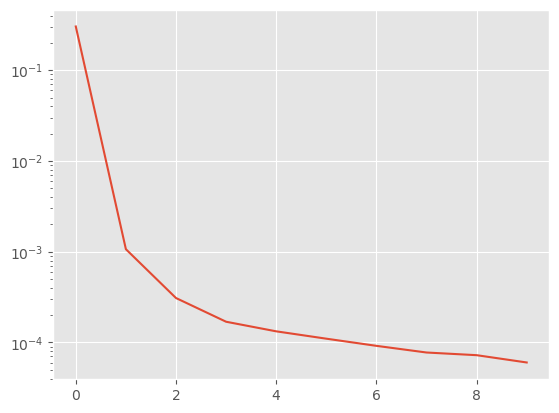

In [60]:
model.train()
optimizer.train()
for epoch in range(n_epochs):  # number of epochs
    epoch_losses = []

    for batch in tqdm(ds_full_loader):
        # Zero the gradients
        optimizer.zero_grad()

        batch = batch.to(device)

        # Forward pass
        outputs = model(batch.mT)

        # Compute loss
        loss = multistep_loss(batch, outputs.mT)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
    
    epoch_loss = np.mean(epoch_losses)
    losses.append(epoch_loss)
    losses_verbose.append(epoch_losses)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss}")

model.eval()
optimizer.eval()

plt.plot(losses)
plt.yscale('log')

In [62]:
model.cpu()
torch.save(model.state_dict(), "./tmpmodel.pt")


In [92]:
model.load_state_dict(torch.load("./tmpmodel.pt"))

<All keys matched successfully>

In [103]:
with torch.no_grad():
    display(model(torch.rand(8, 2, 249)).shape)
    # display(model(torch.rand(8, 249, 2)).shape)

torch.Size([8, 2, 5, 1])

In [104]:
x = torch.rand(1, 2, 249)
torch.onnx.export(model, x, "aaaaa.onnx")